In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

Load the points.

In [2]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.head(), spiral.head()

(        x        y
 0  2.7147  0.81472
 1  2.8054  0.94572
 2  2.0253  0.20682
 3  2.8096  1.03310
 4  2.5257  0.79188,
        x     y  label
 0  31.95  7.95      3
 1  31.15  7.30      3
 2  30.45  6.65      3
 3  29.70  6.00      3
 4  28.90  5.55      3)

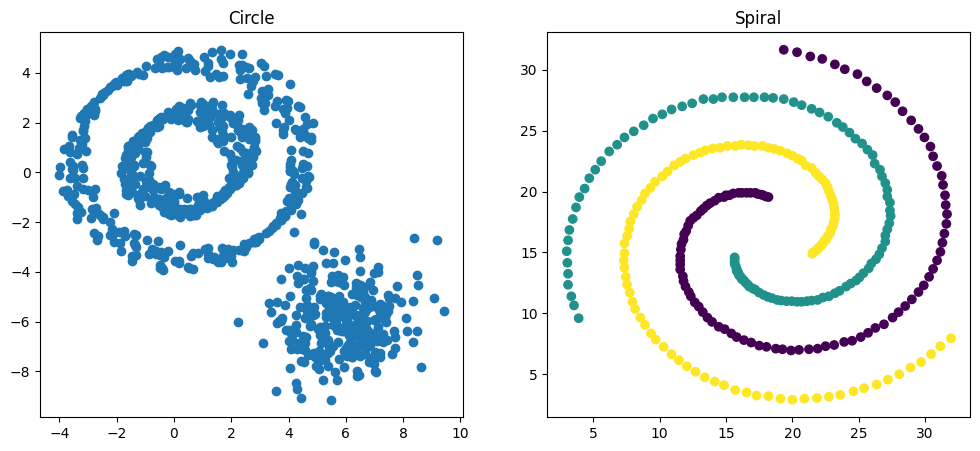

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(circle['x'],circle['y'])
ax[0].set_title('Circle')
ax[1].scatter(spiral['x'],spiral['y'],c=spiral['label'])
ax[1].set_title('Spiral')
plt.show()

In [4]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

Define the similarity function.

In [5]:
def create_similarity_matrix(X, sigma): 
    n_points = X.shape[0]
    similarity_matrix = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            similarity_matrix[i, j] = np.exp(-(np.linalg.norm(X[i] - X[j]))**2 / (2 * sigma**2))

    return similarity_matrix


Given a set of data points X and the similarity function, construct the k-nearest neighborhood similarity graph and its adjacency
matrix W. 

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

def create_adjacency_matrix(X, k, sigma=1):        
    similarity_matrix = create_similarity_matrix(X, sigma)
    np.fill_diagonal(similarity_matrix, 0)  # diagonal elements are zero by definition
    # keep only the k highest values for each row/columns in the similarity matrix
    n_points = similarity_matrix.shape[0]
    W = np.zeros_like(similarity_matrix)

    for i in range(n_points):
        row = similarity_matrix[i]
        top_k_indices = np.argsort(row)[-k:]
        W[i, top_k_indices] = row[top_k_indices]

    W = np.maximum(W,W.T) # so that W is symmetric
    return W
 

In [16]:
W = create_adjacency_matrix(circle_points, 10)

Construct the degree matrix D and the Laplacian matrix L = D −W . 

In [17]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :]!=0)    

In [ ]:
W = csr_matrix(W)
D = csr_matrix(D)

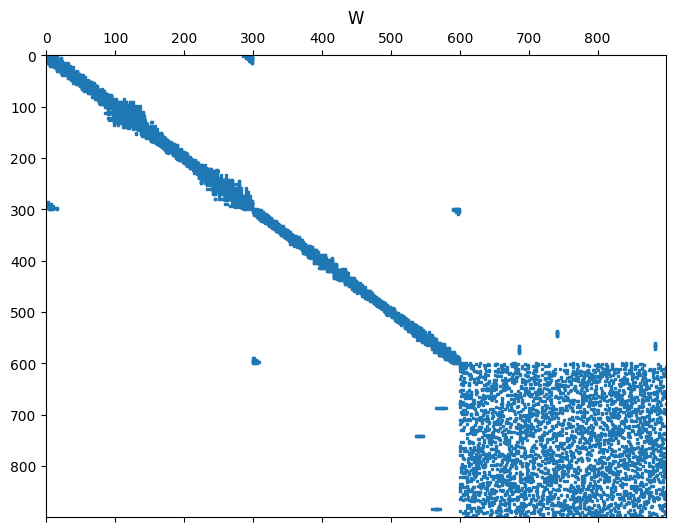

In [18]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

In [ ]:
L = D - W